# Transfer Learning with NASNETMobile

In [1]:
# Importing necessary modules
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-08-10 18:47:32.510701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 18:47:33.868379: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 18:47:33.876734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 18:47:37.500626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Loading data from custom module and defining image size
import data_loader

image_size = (224, 224)
train_ds, val_ds = data_loader.load_data()

Found 202 files belonging to 2 classes.
Using 162 files for training.
Using 40 files for validation.


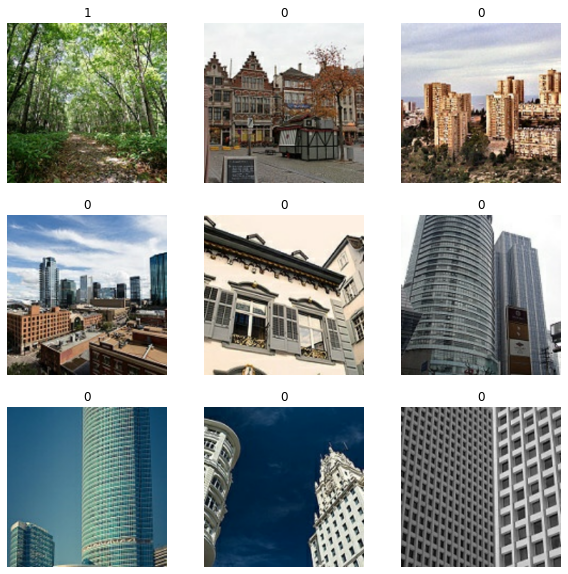

In [3]:
# Testing visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
# Building a transfer learning model (w/ NasNetMobile architecture)
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of NasNetMobile and freeze the weights
    backbone = keras.applications.NASNetMobile(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.nasnet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [5]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

19993432/19993432 [==============================] - 1s 0us/step


In [6]:
# Training the model
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
17/17 [==============================] - 42s 1s/step - loss: 0.6298 - acc: 0.5370 - val_loss: 0.5195 - val_acc: 0.5250
Epoch 2/8
17/17 [==============================] - 11s 664ms/step - loss: 0.4660 - acc: 0.6852 - val_loss: 0.4137 - val_acc: 0.8500
Epoch 3/8
17/17 [==============================] - 11s 641ms/step - loss: 0.3554 - acc: 0.8765 - val_loss: 0.3377 - val_acc: 0.9250
Epoch 4/8
17/17 [==============================] - 15s 893ms/step - loss: 0.3049 - acc: 0.8765 - val_loss: 0.2820 - val_acc: 0.9250
Epoch 5/8
17/17 [==============================] - 11s 654ms/step - loss: 0.2511 - acc: 0.9259 - val_loss: 0.2404 - val_acc: 0.9250
Epoch 6/8
17/17 [==============================] - 10s 627ms/step - loss: 0.2205 - acc: 0.9630 - val_loss: 0.2090 - val_acc: 0.9250
Epoch 7/8
17/17 [==============================] - 11s 634ms/step - loss: 0.2012 - acc: 0.9383 - val_loss: 0.1849 - val_acc: 0.9500
Epoch 8/8
17/17 [==============================] - 11s 668ms/step - loss: 0.171

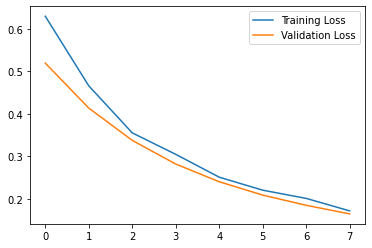

In [7]:
# Examining the learning curves
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

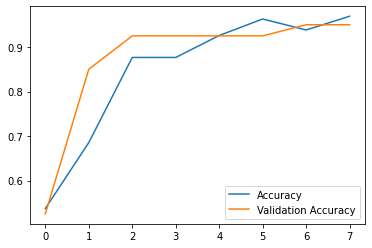

In [8]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()

In [9]:
# Saving transfer learning model
model2.save('NASNetMobile_model.keras')